In [0]:
# Importação das bibliotecas necessárias
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.sql import SparkSession
import logging
from requests.exceptions import RequestException

# Função para extrair dados do conteúdo HTML
def extrair_dados_de_conteudo_html(html: str) -> pd.DataFrame:
    sopa = BeautifulSoup(html, "html.parser")
    tabelas = sopa.find_all("table")
    resultados = []
    
    # Itera sobre todas as tabelas encontradas no HTML
    for tabela in tabelas:
        linhas = tabela.find_all("tr")
        
        # Itera sobre todas as linhas de cada tabela
        for linha in linhas:
            celulas = linha.find_all(["td", "th"])
            registro = []
            
            # Itera sobre todas as células de cada linha
            for celula in celulas:
                celula_html = str(celula)
                celula_texto = re.search(r'<a href=".*?">(.*?)</a>', celula_html)
                # Adiciona o texto da célula ao registro
                registro.append(celula_texto.group(1) if celula_texto else celula.text.strip())
                
            # Adiciona o registro à lista de resultados
            resultados.append(registro)
    
    # Converte os resultados em um DataFrame pandas
    df = pd.DataFrame(resultados)
    
    # Extrai a primeira linha como nomes das colunas
    nomes_colunas = df.iloc[0]
    df.columns = nomes_colunas
    # Remove a primeira linha do DataFrame
    df = df[1:] 
    return df

# Função para extrair dados do URL fornecido
def extrair(url: str) -> pd.DataFrame:
    resposta = requests.get(url, timeout=20)
    conteudo_html = resposta.text
    return extrair_dados_de_conteudo_html(conteudo_html)

# Configurando logging
logging.basicConfig(filename='/extrair_erro.log', level=logging.ERROR)

# Criando uma sessão Spark
spark = SparkSession.builder.appName("Extrair_dados").getOrCreate()

# URL da página de estatísticas da NBA
link_nba = 'https://www.basketball-reference.com/leagues/NBA_2024_per_game.html#per_game_stats'

# Chamando a função de extração para obter os dados
dados = extrair(link_nba)

# Processando os nomes das colunas
nomes_colunas = [nome.replace('%', 'Perc') if nome else 'ID' for nome in dados.columns]

# Substituir o início da string se for um número
nomes_colunas_processadas = [f"{nome[1:]}{nome[0]}" if nome[0].isdigit() else nome for nome in nomes_colunas]

# Atualiza os nomes das colunas no DataFrame
dados.columns = nomes_colunas_processadas

# Filtra as linhas que não são títulos
dados = dados[dados['Rk'] != 'Rk']

# Definindo variáveis usadas no código abaixo
caminho_delta = "hive_metastore/default/caminho/delta"
caminho_checkpoint = "/caminho/checkpoint"

# Convertendo o DataFrame pandas para DataFrame PySpark
df_ = spark.createDataFrame(dados)
    
# Transformando colunas de string para tipos apropriados
colunas_inteiras = ['Age', 'G', 'GS']
colunas_floats = ['MP', 'FG', 'FGA', 'FGPerc', 'P3', 'PA3', 'PPerc3', 'P2', 'PA2',
                 'PPerc2', 'eFGPerc', 'FT', 'FTA', 'FTPerc', 'ORB', 'DRB', 'TRB',
                 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']

# Convertendo colunas inteiras
for nome_coluna in colunas_inteiras:
    df_ = df_.withColumn(nome_coluna, df_[nome_coluna].cast(IntegerType()))

# Convertendo colunas flutuantes
for nome_coluna in colunas_floats:
    df_ = df_.withColumn(nome_coluna, df_[nome_coluna].cast(DoubleType()))

# Salvando o DataFrame como uma tabela Delta no Hive Metastore
df_.write.mode("overwrite").format("delta").saveAsTable("Dados_Jogadores_NBA_24")




In [0]:
%sql
-- Criação 'dados_nba_preparados'
CREATE OR REPLACE TABLE
   dados_nba_preparados (
     Classificacao_Equipe int,
     Nome_Equipe string,
     Media_Pontos double,
     Maximo_Pontos double,
     Media_Percentage_Acerto double,
     Media_Rebotes_Defensivos double,
     Media_Rebotes_Ofensivos double,
     Media_TurnOver double,
     Media_Classificacao_Jogador double,
     Minima_Classificacao_Jogador double,
     Metricas_Personalizadas double
   );

-- Inserção de dados na tabela 'dados_nba_preparados'
INSERT INTO
   dados_nba_preparados

-- Definição de uma CTE (Common Table Expression) para calcular estatísticas médias para cada equipe
WITH estatisticas_equipes AS (
     SELECT
         Tm AS Equipe,
         AVG(PTS) AS media_pontos,
         AVG(FGPerc) AS media_percentage_acerto,
         AVG(DRB) AS media_rebotes_defensivos,
         AVG(ORB) AS media_rebotes_ofensivos,
         AVG(TOV) AS media_turnover,
         AVG(Rk) AS media_classificacao_jogador
     FROM Dados_Jogadores_NBA_24
     GROUP BY Tm
 ),

-- Definição de uma CTE para calcular os valores mínimos e máximos de cada estatística por equipe
min_max_valores AS (
     SELECT
         Tm AS Equipe,
         MIN(PTS) AS min_pontos,
         MAX(PTS) AS max_pontos,
         MIN(FGPerc) AS min_percentage_acerto,
         MAX(FGPerc) AS max_percentage_acerto,
         MIN(DRB) AS min_rebotes_defensivos,
         MAX(DRB) AS max_rebotes_defensivos,
         MIN(ORB) AS min_rebotes_ofensivos,
         MAX(ORB) AS max_rebotes_ofensivos,
         MIN(TOV) AS min_turnover,
         MAX(TOV) AS max_turnover,
         MIN(RK) AS min_classificacao_jogador,
         MAX(RK) AS max_classificacao_jogador
     FROM Dados_Jogadores_NBA_24
     GROUP BY Tm
 ),

-- Definição de uma CTE para calcular os valores normalizados de cada estatística por equipe
equipes_rankeadas AS (
     SELECT
         e.Equipe,
         e.media_pontos,
         e.media_percentage_acerto,
         e.media_rebotes_defensivos,
         e.media_rebotes_ofensivos,
         e.media_turnover,
         e.media_classificacao_jogador,
         (
         e.media_pontos - mmv.min_pontos
         ) / (
         mmv.max_pontos - mmv.min_pontos
         ) AS pontos_normalizados,
         (
         e.media_percentage_acerto - mmv.min_percentage_acerto
         ) / (
         mmv.max_percentage_acerto - mmv.min_percentage_acerto
         ) AS percentage_acerto_normalizado,
         (
         e.media_rebotes_defensivos - mmv.min_rebotes_defensivos
         ) / (
         mmv.max_rebotes_defensivos - mmv.min_rebotes_defensivos
         ) AS rebotes_defensivos_normalizados,
         (
         e.media_rebotes_ofensivos - mmv.min_rebotes_ofensivos
         ) / (
         mmv.max_rebotes_ofensivos - mmv.min_rebotes_ofensivos
         ) AS rebotes_ofensivos_normalizados,
         (
         e.media_turnover - mmv.min_turnover
         ) / (
         mmv.max_turnover - mmv.min_turnover
         ) AS turnover_normalizado,
         (
         e.media_classificacao_jogador - mmv.min_classificacao_jogador
         ) / (
         mmv.max_classificacao_jogador - mmv.min_classificacao_jogador
         ) AS classificacao_jogador_normalizado,
         RANK() OVER (ORDER BY e.media_pontos DESC) AS classificacao_equipes
     FROM estatisticas_equipes e
     JOIN min_max_valores mmv ON e.Equipe = mmv.Equipe
 ),

-- Definição de uma CTE para rankear as equipes com base em uma métrica personalizada
equipes_rankeadas_2 AS (
     SELECT
         Equipe,
         media_pontos,
         media_percentage_acerto,
         media_rebotes_defensivos,
         media_rebotes_ofensivos,
         media_turnover,
         pontos_normalizados,
         media_classificacao_jogador,
         percentage_acerto_normalizado,
         rebotes_defensivos_normalizados,
         rebotes_ofensivos_normalizados,
         turnover_normalizado,
         classificacao_jogador_normalizado,
         RANK() OVER (ORDER BY pontos_normalizados - turnover_normalizado + rebotes_defensivos_normalizados DESC) AS classificacao_equipes
     FROM equipes_rankeadas
 )

-- Output dos resultados unindo os dados das CTEs 'equipes_rankeadas_2' e 'min_max_valores' e filtrando as top 100 equipes
SELECT
     eqr2.classificacao_equipes,
     eqr2.Equipe,
     ROUND(eqr2.media_pontos, 2),
     ROUND(mmv.max_pontos, 2) AS max_pontos,
     ROUND(eqr2.media_percentage_acerto, 2),
     ROUND(eqr2.media_rebotes_defensivos, 2) AS media_reb_defensivos,
     ROUND(eqr2.media_rebotes_ofensivos, 2) AS media_reb_ofensivos,
     ROUND(eqr2.media_turnover, 2),
     ROUND(eqr2.media_classificacao_jogador, 2) AS media_classificacao,
     ROUND(mmv.min_classificacao_jogador, 2) AS min_classificacao,
     ROUND(pontos_normalizados - turnover_normalizado + rebotes_defensivos_normalizados, 2) AS metricas_personalizadas
FROM
    equipes_rankeadas_2 eqr2
    LEFT JOIN min_max_valores mmv ON mmv.Equipe = eqr2.Equipe
WHERE
     eqr2.classificacao_equipes <= 100;


num_affected_rows,num_inserted_rows
31,31


In [0]:
from pyspark.sql import SparkSession

# Criar uma SparkSession
spark = SparkSession.builder.getOrCreate()

# Validação da qualidade dos dados
# Ler a tabela de dados preparados (dados_nba_preparados) em um DataFrame Spark
dados_nba_preparados = spark.table("dados_nba_preparados")

# Contar o número de linhas duplicadas
duplicatas = (
  dados_nba_preparados
  .groupBy("Classificacao_Equipe", "Nome_Equipe", "Media_Pontos", "Maximo_Pontos", "Media_Percentage_Acerto",
           "Media_Rebotes_Defensivos", "Media_Rebotes_Ofensivos", "Media_TurnOver",
           "Media_Classificacao_Jogador", "Minima_Classificacao_Jogador", "Metricas_Personalizadas")
  .count()
  .filter("count > 1")
)

# Assegurar que o número de linhas duplicadas é zero
assert duplicatas.count() == 0, "Linhas duplicadas encontradas em dados_nba_preparados"


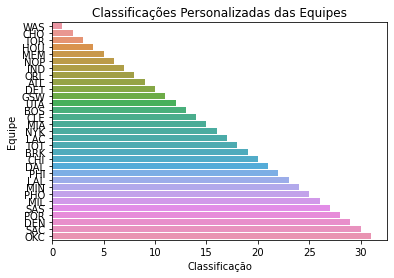

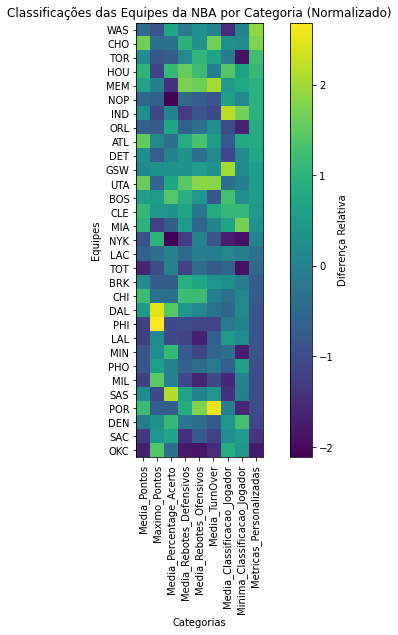

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession

# Criar uma SparkSession
spark = SparkSession.builder.getOrCreate()

query = "SELECT * FROM dados_nba_preparados"
query_result = spark.sql(query)
dados_nba_preparados = query_result.toPandas()

dados_nba_preparados.head()

# Criar gráfico de barras com as classificações das equipes
sns.barplot(y=dados_nba_preparados.Nome_Equipe, x=dados_nba_preparados.Classificacao_Equipe)
plt.title('Classificações Personalizadas das Equipes')
plt.xlabel('Classificação')
plt.ylabel('Equipe')
plt.show()

# Criar um mapa de calor para as métricas das equipes
import numpy as np

# Criar uma cópia dos dados e remover a coluna de nome da equipe
dados = dados_nba_preparados.copy()
dados = dados.drop('Nome_Equipe', axis=1)
dados = dados.drop('Classificacao_Equipe', axis=1)

# Normalizar os dados por categoria
dados = (dados - dados.mean()) / dados.std()

# Configurar o gráfico
categorias = list(dados.columns)
equipes = list(dados_nba_preparados['Nome_Equipe'].values)
x = np.arange(len(categorias))
y = np.arange(len(equipes))
X, Y = np.meshgrid(x, y)

# Criar o gráfico
plt.figure(figsize=(10, 8))
plt.imshow(dados, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Diferença Relativa')
plt.xticks(x, categorias, rotation=90)
plt.yticks(y, equipes)
plt.xlabel('Categorias')
plt.ylabel('Equipes')
plt.title('Classificações das Equipes da NBA por Categoria (Normalizado)')
plt.show()

In [0]:
%sql 

SELECT
    Nome_Equipe,
    Media_Percentage_Acerto
FROM dados_nba_preparados
WHERE Media_Percentage_Acerto = (SELECT MAX(Media_Percentage_Acerto) FROM dados_nba_preparados)
   OR Media_Percentage_Acerto = (SELECT MIN(Media_Percentage_Acerto) FROM dados_nba_preparados);

Nome_Equipe,Media_Percentage_Acerto
NOP,0.39
NYK,0.39
SAS,0.51


In [0]:
%sql

SELECT 
    Nome_Equipe,
    Media_Pontos
FROM dados_nba_preparados
ORDER BY Media_Pontos DESC
limit 10;

Nome_Equipe,Media_Pontos
CHO,9.3
UTA,9.26
ATL,9.21
CHI,8.96
POR,8.94
CLE,8.89
HOU,8.83
MIA,8.8
MEM,8.61
BOS,8.53


In [0]:
%sql 
   select Player,
    Age,
    MP,
    PTS,
    FGPerc,
    DRB,
    ORB,
    TOV
FROM Dados_Jogadores_NBA_24
ORDER BY (PTS + 1.5 * DRB) DESC
limit 10;

Player,Age,MP,PTS,FGPerc,DRB,ORB,TOV
Joel Embiid,29,33.6,34.7,0.529,8.6,2.4,3.8
Luka DonÄiÄ,24,37.5,33.9,0.487,8.4,0.8,4.0
Giannis Antetokounmpo,29,35.2,30.4,0.611,8.8,2.7,3.4
Nikola JokiÄ,28,34.6,26.4,0.583,9.5,2.8,3.0
Anthony Davis,30,35.5,24.7,0.556,9.5,3.1,2.1
Jayson Tatum,25,35.7,26.9,0.471,7.2,0.9,2.5
Shai Gilgeous-Alexander,25,34.0,30.1,0.535,4.7,0.9,2.2
Kevin Durant,35,37.2,27.1,0.523,6.1,0.5,3.3
LeBron James,39,35.3,25.7,0.54,6.4,0.9,3.5
Domantas Sabonis,27,35.7,19.4,0.594,10.1,3.6,3.3


In [0]:
%sql
SELECT 
  Player,
    Age,
    MP,
    PTS,
    FGPerc,
    DRB,
    ORB,
    TOV
FROM Dados_Jogadores_NBA_24

ORDER BY (PTS + 1.5 * DRB) DESC
limit 10;



Player,Age,MP,PTS,FGPerc,DRB,ORB,TOV
Joel Embiid,29,33.6,34.7,0.529,8.6,2.4,3.8
Luka DonÄiÄ,24,37.5,33.9,0.487,8.4,0.8,4.0
Giannis Antetokounmpo,29,35.2,30.4,0.611,8.8,2.7,3.4
Nikola JokiÄ,28,34.6,26.4,0.583,9.5,2.8,3.0
Anthony Davis,30,35.5,24.7,0.556,9.5,3.1,2.1
Jayson Tatum,25,35.7,26.9,0.471,7.2,0.9,2.5
Shai Gilgeous-Alexander,25,34.0,30.1,0.535,4.7,0.9,2.2
Kevin Durant,35,37.2,27.1,0.523,6.1,0.5,3.3
LeBron James,39,35.3,25.7,0.54,6.4,0.9,3.5
Domantas Sabonis,27,35.7,19.4,0.594,10.1,3.6,3.3


In [0]:
%sql
SELECT 
  Player,
    Age,
    MP,
    PTS,
    FGPerc,
    DRB,
    ORB,
    TOV
FROM Dados_Jogadores_NBA_24
ORDER BY ( DRB + 1.5 * PTS) DESC
limit 10;

Player,Age,MP,PTS,FGPerc,DRB,ORB,TOV
Joel Embiid,29,33.6,34.7,0.529,8.6,2.4,3.8
Luka DonÄiÄ,24,37.5,33.9,0.487,8.4,0.8,4.0
Giannis Antetokounmpo,29,35.2,30.4,0.611,8.8,2.7,3.4
Shai Gilgeous-Alexander,25,34.0,30.1,0.535,4.7,0.9,2.2
Nikola JokiÄ,28,34.6,26.4,0.583,9.5,2.8,3.0
Jayson Tatum,25,35.7,26.9,0.471,7.2,0.9,2.5
Kevin Durant,35,37.2,27.1,0.523,6.1,0.5,3.3
Anthony Davis,30,35.5,24.7,0.556,9.5,3.1,2.1
Jalen Brunson,27,35.4,28.7,0.479,3.1,0.6,2.4
LeBron James,39,35.3,25.7,0.54,6.4,0.9,3.5


S

In [0]:
%sql
select * from dados_nba_preparados limit 10

Classificacao_Equipe,Nome_Equipe,Media_Pontos,Maximo_Pontos,Media_Percentage_Acerto,Media_Rebotes_Defensivos,Media_Rebotes_Ofensivos,Media_TurnOver,Media_Classificacao_Jogador,Minima_Classificacao_Jogador,Metricas_Personalizadas
1,WAS,7.8,22.2,0.47,2.4,0.87,0.95,231.96,106.0,0.47
2,CHO,9.3,23.9,0.44,2.67,0.87,1.18,294.62,113.0,0.46
3,TOR,8.27,22.2,0.43,2.49,0.98,1.04,281.23,1.0,0.42
4,HOU,8.83,21.1,0.48,2.8,1.0,0.94,333.59,139.0,0.41
5,MEM,8.61,25.1,0.41,2.84,1.07,1.23,301.03,145.0,0.4
6,NOP,7.75,22.9,0.39,2.34,0.72,0.83,306.2,111.0,0.4
7,IND,8.32,21.3,0.45,2.14,0.7,0.8,359.64,196.0,0.4
8,ORL,7.67,22.6,0.47,2.29,0.77,0.98,250.11,13.0,0.39
9,ATL,9.21,25.7,0.44,2.64,1.02,1.02,257.53,147.0,0.39
10,DET,8.33,22.7,0.45,2.53,0.77,0.97,248.39,112.0,0.38
